In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
!ls *.yaml

speaker-count.yaml  speakernet_model_config.yaml  titanl_model_config.yaml


In [3]:
labels = [
    '0 speaker',
    '1 speaker',
    '2 speakers',
    '3 speakers',
    '4 speakers',
    '5 speakers',
    'more than 5 speakers',
]

In [4]:
import yaml

config = 'speakernet_model_config.yaml'
with open(config) as stream:
    try:
        d = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        raise ValueError('invalid yaml')

In [5]:
d['decoder']['num_classes'] = len(labels)
d['decoder']['angular'] = False

In [6]:
with open('speaker-count.yaml', 'w') as fopen:
    yaml.dump(d, fopen)

In [7]:
from malaya_speech.utils import nemo_featurization
from malaya_speech.nemo import conv_asr
import malaya_speech
from malaya_speech.utils.padding import sequence_1d
from malaya_boilerplate.torch_utils import to_tensor_cuda, to_numpy
import numpy as np
import torch

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()

        preprocessor = d['preprocessor'].copy()
        preprocessor_target = (preprocessor.pop('_target_', None) or preprocessor.pop('cls', None)).split('.')[-1]
        if 'params' in preprocessor:
            preprocessor = preprocessor['params']

        encoder = d['encoder'].copy()
        encoder_target = (encoder.pop('_target_', None) or encoder.pop('cls', None)).split('.')[-1]
        if 'params' in encoder:
            encoder = encoder['params']

        decoder = d['decoder'].copy()
        decoder_target = (decoder.pop('_target_', None) or decoder.pop('cls', None)).split('.')[-1]
        if 'params' in decoder:
            decoder = decoder['params']

        self.preprocessor = getattr(nemo_featurization, preprocessor_target)(**preprocessor)
        self.encoder = getattr(conv_asr, encoder_target)(**encoder)
        self.decoder = getattr(conv_asr, decoder_target)(**decoder)
    
    def forward(self, inputs):
        """
        Vectorize inputs.

        Parameters
        ----------
        inputs: List[np.array]
            List[np.array] or List[malaya_speech.model.frame.Frame].
        """

        cuda = next(self.parameters()).is_cuda
        inputs, lengths = sequence_1d(
            inputs, return_len=True
        )
        inputs = to_tensor_cuda(torch.Tensor(inputs.astype(np.float32)), cuda)
        lengths = to_tensor_cuda(torch.Tensor(lengths), cuda)
        o_processor = self.preprocessor(inputs, lengths)
        o_encoder = self.encoder(*o_processor)
        return self.decoder(*o_encoder)

2023-08-08 16:50:44.109334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:50:44.305637: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 16:50:45.335926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-08 16:50:45.336052: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

/home/husein/.local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


`pyaudio` is not available, `malaya_speech.streaming.pyaudio` is not able to use.


In [8]:
model = Model()

In [9]:
!ls -lh speakernet-speaker-count-v2-bf16-mixed

total 139M
-rw-r--r-- 1 husein husein 47M Ogos  5 14:16 'model-epoch=00-step=320000.ckpt'
-rw-r--r-- 1 husein husein 47M Ogos  5 15:06 'model-epoch=00-step=330000.ckpt'
-rw-r--r-- 1 husein husein 47M Ogos  5 16:00 'model-epoch=00-step=340000.ckpt'


In [10]:
current_model_dict = model.state_dict()
loaded_state_dict = torch.load('speakernet-speaker-count-v2-bf16-mixed/model-epoch=00-step=340000.ckpt', map_location=torch.device('cpu'))['state_dict']
new_state_dict = {k:v if v.size() == current_model_dict[k].size() else current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [11]:
torch.save(model.state_dict(), 'speaker-count-speakernet.pt')

In [12]:
model.load_state_dict(torch.load('speaker-count-speakernet.pt', map_location='cpu'))

<All keys matched successfully>

In [13]:
_ = model.eval()

In [14]:
from glob import glob
import random

vctk = random.sample(glob('/home/husein/ssd2/wav48_silence_trimmed/*/*.flac'), 10000)

In [15]:
y, _ = malaya_speech.load(vctk[0])
noise, _ = malaya_speech.load('speech/noise/noise-free-sound-0322.wav')
podcast, _ = malaya_speech.load('speech/podcast/toodia.mp3')

In [17]:
frames = malaya_speech.generator.frames(podcast, 300, 16000, False)

In [18]:
%%time

o = model([f.array for f in frames])[0]

CPU times: user 7.77 s, sys: 4.29 s, total: 12.1 s
Wall time: 15.2 s


In [19]:
np.argmax(o.detach().numpy(), axis = 1)

array([0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 3, 3, 3, 1, 1, 2, 4, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 2, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1])

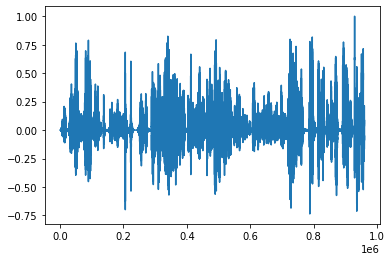

In [20]:
import matplotlib.pyplot as plt

plt.plot(podcast)

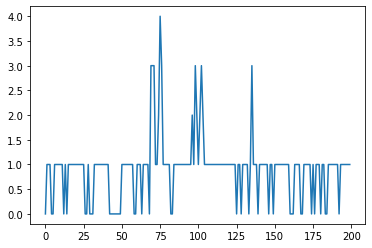

In [21]:
plt.plot(np.argmax(o.detach().numpy(), axis = 1))

In [22]:
from malaya_boilerplate.huggingface import upload_dict

In [23]:
files_mapping = {'speaker-count-speakernet.pt': 'model_weights.ckpt',
                 'speaker-count.yaml': 'model_config.yaml',}
upload_dict(model = 'nemo-speaker-count-speakernet', files_mapping = files_mapping, username = 'huseinzol05')

409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-64d2023a-2357440c686a2f024a66c10a;203defee-698f-4f97-a8b4-8b9c3e1e9efd)

You already created this model repo


speaker-count-speakernet.pt:   0%|          | 0.00/16.2M [00:00<?, ?B/s]